In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random

In [2]:
train_files = os.listdir(r"C:\Airbus-ship-segm\train_v2")
test_files = os.listdir(r"C:\Airbus-ship-segm\test_v2")
print(f"Train images: {len(train_files)} \nTest images: {len(test_files)}")
print("Image size:", PIL.Image.open(r"C:/Airbus-ship-segm/train_v2/00021ddc3.jpg").size)

Train images: 192556 
Test images: 15606
Image size: (768, 768)


In [3]:
def load_img(filename, shape = (768, 768)):
    """
    gets np.array in rgb rofmat for filename
    """
    img = np.array(PIL.Image.open(r"C:/Airbus-ship-segm/train_v2/"+filename).resize(shape))
    return img

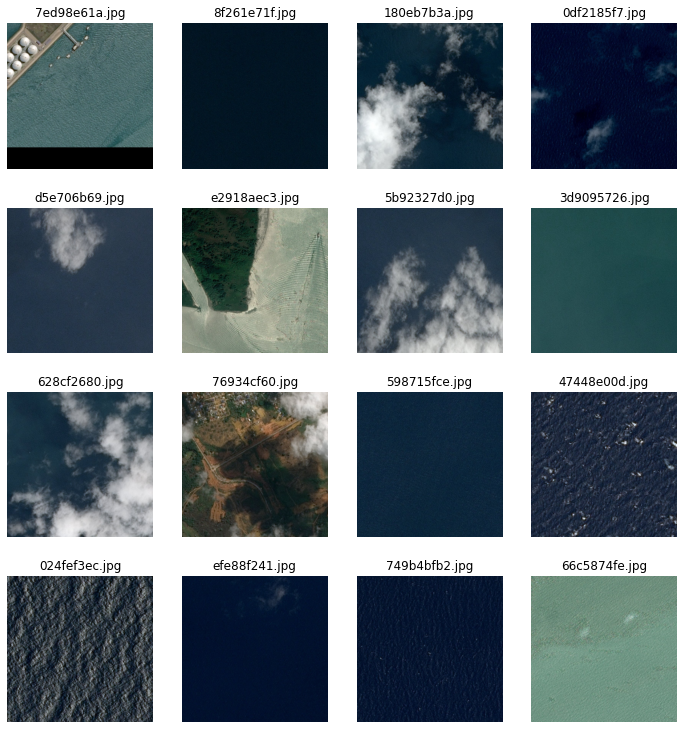

In [24]:
plt.rcParams.update({'font.size': 10})
_, axes_list = plt.subplots(4, 4, figsize=(12, 13)) 

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(train_files) 
        ax.imshow(load_img(img, shape=(256, 256)))
        ax.set_title(img)

In [20]:
train_df = pd.read_csv('train_ship_segmentations_v2.csv', index_col=0)
#train_df = train_df[train_df['ImageId'] != '6384c3e78.jpg']
train_df.head()

,EncodedPixels
ImageId,
00003e153.jpg,NaN
0001124c7.jpg,NaN
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
df = train_df.copy()
df['HasShip'] = df['EncodedPixels'].notnull()
df = df.groupby("ImageId").agg({'HasShip': ['first', 'sum']})
df.columns = ['HasShip', 'ShipsCount']
df.head()

,HasShip,ShipsCount
ImageId,,
00003e153.jpg,False,0
0001124c7.jpg,False,0
000155de5.jpg,True,1
000194a2d.jpg,True,5
0001b1832.jpg,False,0


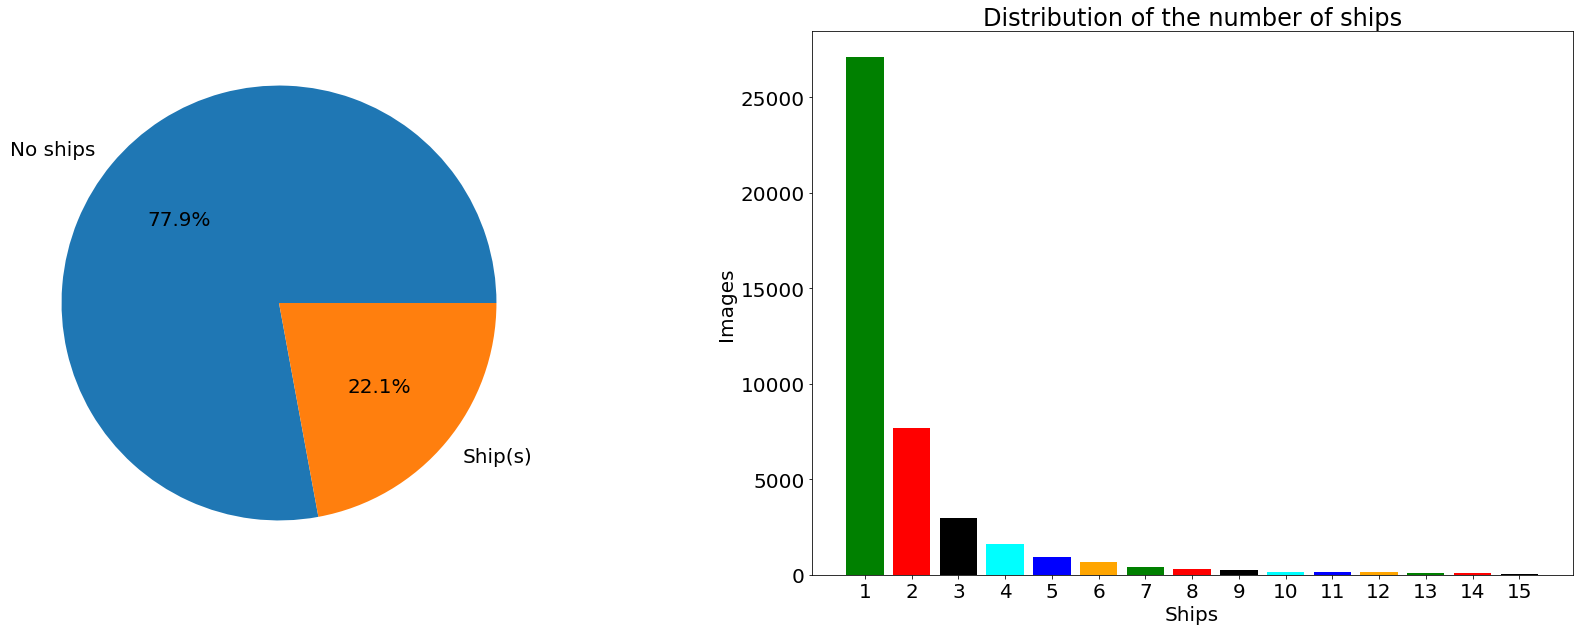

In [7]:
with_ships = df['HasShip'].sum()
all_image = len(df)
no_ships = all_image - with_ships
ships_distribution = df.loc[df['HasShip'], 'ShipsCount'].value_counts().sort_index()

plt.rcParams.update({'font.size': 20})
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

axes[0].pie([no_ships, with_ships], labels=['No ships', 'Ship(s)'], autopct='%1.1f%%');

axes[1].bar(range(1,16), ships_distribution, tick_label = range(1,16), color=['green', 'red', 'black', 'cyan', 'blue', 'orange']);
axes[1].set_title('Distribution of the number of ships')
axes[1].set_xlabel("Ships")
axes[1].set_ylabel("Images");

In [8]:
def get_mask(img_name):
    """
    input: img_name as a string
    output: mask as a np.array(768,768)
    """
    rle = [int(x) for x in " ".join(train_df[train_df.index.isin([img_name])]['EncodedPixels'].values).split()]
    rle_pairs= [[rle[i], rle[i+1]] for i in range(0,len(rle),2)]
    pixels = [(pix_pos%768, pix_pos//768) for start,length in rle_pairs for pix_pos in range(start,start+length)]
    mask = np.zeros((768,768))
    mask[tuple(zip(*pixels))] = 1
    return mask
    
def highlight_ships(img_rgb, mask):
    """
    input: image in rgb format, mask as np.array 
    output: image in rgb format with "highlighed" ships 
    """
    for x in range(768):
        for y in range(768):
            if mask[x][y] == 1:
                img_rgb[x][y] = [255,255,0]
    return img_rgb

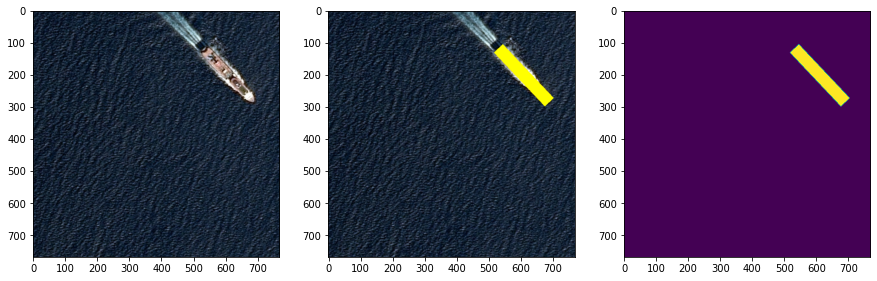

In [35]:
img_name = random.choice(df.loc[df['HasShip'] == True].index)

img = load_img(img_name)
mask = get_mask(img_name)
plt.rcParams.update({'font.size': 10})
_, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(img);
ax[1].imshow(highlight_ships(img,mask));
ax[2].imshow(mask);
